In [1]:
import os
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "src").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
os.chdir(PROJECT_ROOT)



In [2]:
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from src.qoc_common_crab import load_baseline_crab

arrays, policy = load_baseline_crab("outputs/_baseline_crab")
t = arrays["t"]
dt = float(arrays["dt"])
Omega0 = arrays["Omega0"]
Delta0 = arrays["Delta0"]

RUNS = {
    "Adam": Path("outputs/terminal_crab/grape_adam"),
    "Const": Path("outputs/terminal_crab/grape_const"),
    "Linesearch": Path("outputs/terminal_crab/grape_linesearch"),
}

data = {}
for label, run_dir in RUNS.items():
    arrays_path = run_dir / "arrays.npz"
    meta_path = run_dir / "metadata.json"
    if not arrays_path.exists() or not meta_path.exists():
        raise FileNotFoundError(f"Missing results for {label} in {run_dir}")
    with np.load(arrays_path, allow_pickle=False) as arrs:
        cost_terms = {
            "infidelity": np.asarray(arrs["cost_terms_infidelity"], dtype=float),
            "power": np.asarray(arrs["cost_terms_power"], dtype=float),
            "neg": np.asarray(arrs["cost_terms_neg"], dtype=float),
        }
        data[label] = {
            "Omega": np.asarray(arrs["Omega"], dtype=float),
            "Delta": np.asarray(arrs["Delta"], dtype=float),
            "cost_hist": np.asarray(arrs["cost_hist"], dtype=float),
            "cost_terms": cost_terms,
            "times_s": np.asarray(arrs.get("times_s", np.zeros(cost_terms["infidelity"].size)), dtype=float),
        }
    with open(meta_path, "r", encoding="utf-8") as fh:
        metadata = json.load(fh)
    data[label]["metadata"] = metadata
print(f"Loaded results for {', '.join(data.keys())}")


Loaded results for Adam, Const, Linesearch


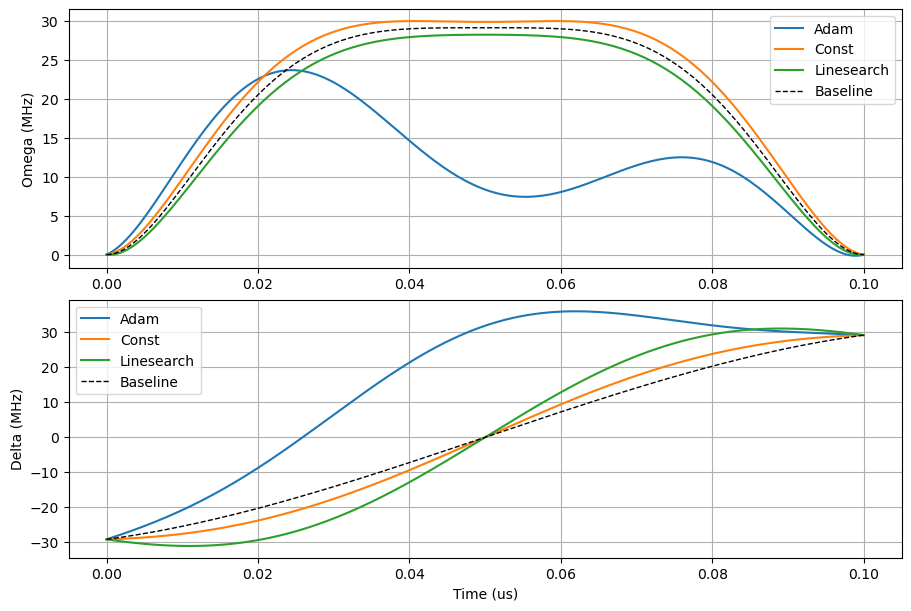

In [3]:
fig, axs = plt.subplots(2, 1, figsize=(9, 6), layout="constrained")
for label, entry in data.items():
    axs[0].plot(t, entry["Omega"] / (2 * np.pi), label=label)
    axs[1].plot(t, entry["Delta"] / (2 * np.pi), label=label)
axs[0].plot(t, Omega0 / (2 * np.pi), "--", color="black", linewidth=1.0, label="Baseline")
axs[1].plot(t, Delta0 / (2 * np.pi), "--", color="black", linewidth=1.0, label="Baseline")
axs[0].set_ylabel("Omega (MHz)")
axs[1].set_ylabel("Delta (MHz)")
axs[1].set_xlabel("Time (us)")
for ax in axs:
    ax.grid(True)
    ax.legend()
plt.show()


C:\Users\yehon\AppData\Local\Temp\ipykernel_23576\3453022728.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


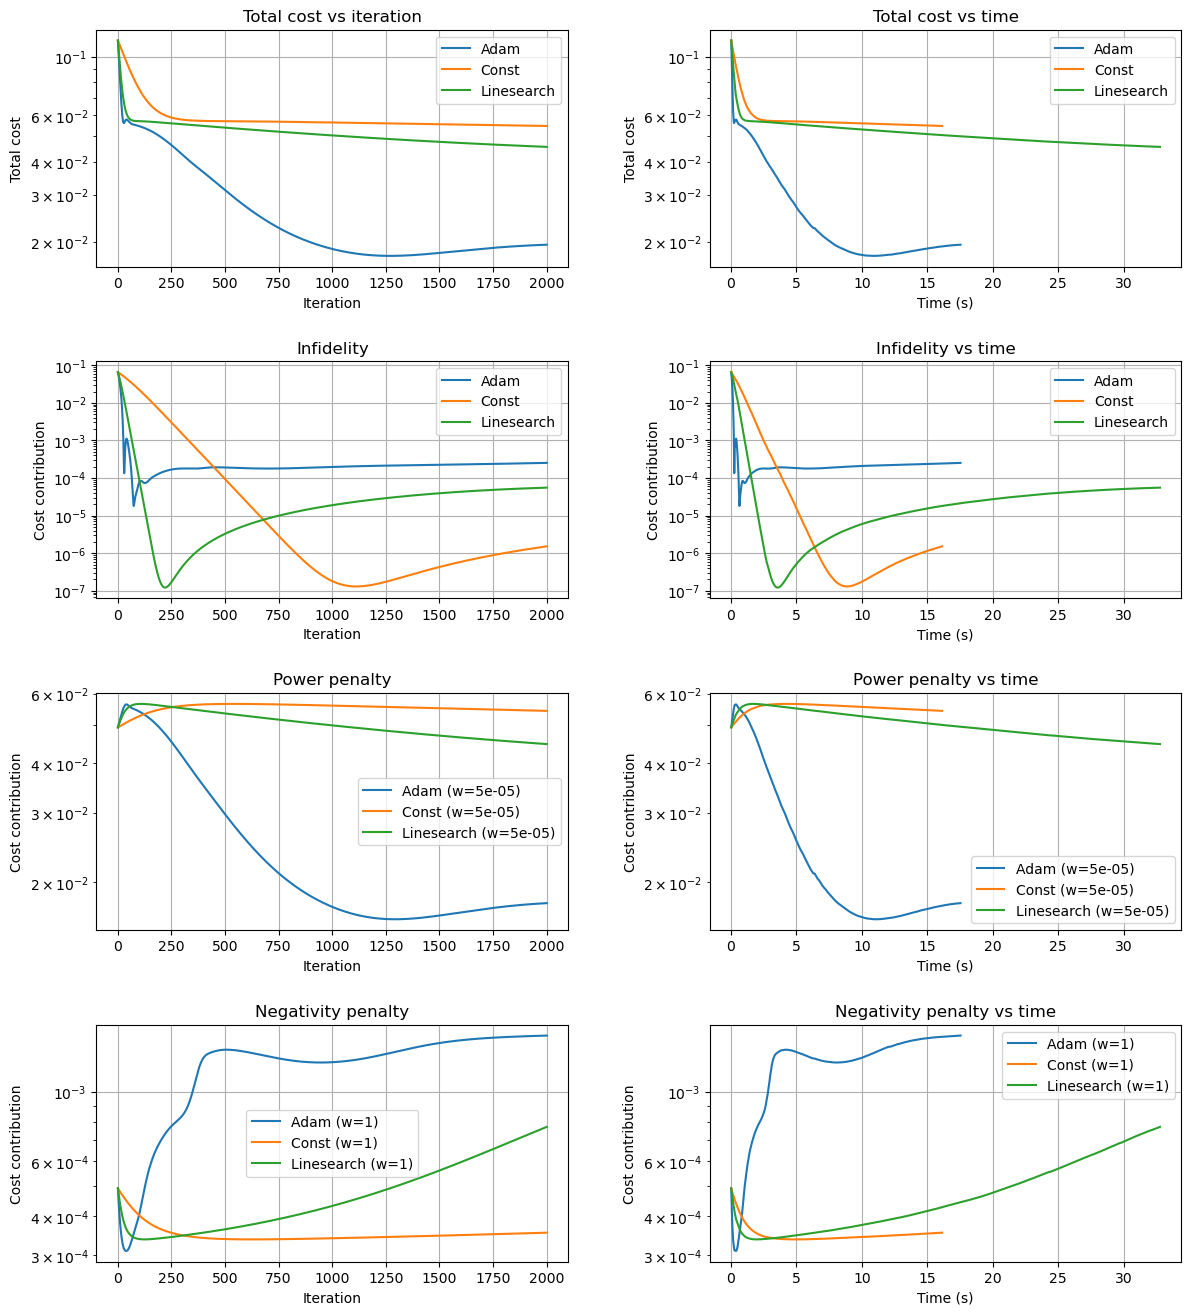

In [5]:
import matplotlib.gridspec as gridspec

# Define the cost terms to plot: (key, display name, weight key in metadata)
term_specs = [
    ("infidelity", "Infidelity", None),
    ("power", "Power penalty", "power_weight"),
    ("neg", "Negativity penalty", "neg_weight"),
]

n_terms = len(term_specs)
fig = plt.figure(figsize=(14, 4 * n_terms + 4))
gs = gridspec.GridSpec(n_terms + 1, 2, figure=fig, wspace=0.3, hspace=0.4)

# First plot: cost vs iteration
ax0 = fig.add_subplot(gs[0, 0])
for label, entry in data.items():
    iters = np.arange(1, entry["cost_hist"].size + 1)
    ax0.semilogy(iters, entry["cost_hist"], label=label)
ax0.set_xlabel("Iteration")
ax0.set_ylabel("Total cost")
ax0.set_title("Total cost vs iteration")
ax0.grid(True)
ax0.legend()

# Second plot: cost vs time
ax1 = fig.add_subplot(gs[0, 1])
for label, entry in data.items():
    times = entry["times_s"]
    if times.size == 0:
        continue
    ax1.semilogy(times, entry["cost_hist"], label=label)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Total cost")
ax1.set_title("Total cost vs time")
ax1.grid(True)
ax1.legend()

# Cost term plots
for i, (key, title, weight_key) in enumerate(term_specs):
    # Plot vs iteration
    ax_iter = fig.add_subplot(gs[i + 1, 0])
    plotted = False
    for label, entry in data.items():
        term = entry["cost_terms"][key]
        if term.size == 0:
            continue
        if key != "infidelity" and not np.any(term > 0):
            continue
        meta = entry["metadata"]
        if weight_key is None:
            display_label = label
        else:
            weight = float(meta.get("penalties", {}).get(weight_key, 0.0))
            display_label = f"{label} (w={weight:g})"
        iters = np.arange(1, term.size + 1)
        ax_iter.semilogy(iters, term, label=display_label)
        plotted = True
    ax_iter.set_xlabel("Iteration")
    ax_iter.set_ylabel("Cost contribution")
    ax_iter.set_title(title)
    ax_iter.grid(True)
    if plotted:
        ax_iter.legend()
    else:
        ax_iter.text(0.5, 0.5, "No data", transform=ax_iter.transAxes, ha="center", va="center")

    # Plot vs time
    ax_time = fig.add_subplot(gs[i + 1, 1])
    plotted = False
    for label, entry in data.items():
        term = entry["cost_terms"][key]
        times = entry["times_s"]
        if term.size == 0 or times.size == 0:
            continue
        if key != "infidelity" and not np.any(term > 0):
            continue
        meta = entry["metadata"]
        if weight_key is None:
            display_label = label
        else:
            weight = float(meta.get("penalties", {}).get(weight_key, 0.0))
            display_label = f"{label} (w={weight:g})"
        ax_time.semilogy(times[: term.size], term, label=display_label)
        plotted = True
    ax_time.set_xlabel("Time (s)")
    ax_time.set_ylabel("Cost contribution")
    ax_time.set_title(f"{title} vs time")
    ax_time.grid(True)
    if plotted:
        ax_time.legend()
    else:
        ax_time.text(0.5, 0.5, "No data", transform=ax_time.transAxes, ha="center", va="center")

plt.tight_layout()
plt.show()
